In [1]:
import os
import random
import time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.models.vgg import VGG
from torchvision import models

from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import csv

In [2]:
H = 256  # image height
W = 1600 # image width
numDefectClasses = 4

train_img_path = 'train_images/'
test_img_path = 'test_images/'
train_image_list = os.listdir(train_img_path)

In [3]:
#https://github.com/pochih/FCN-pytorch/blob/master/python/fcn.py

class FCN32s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)

        score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)


class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg11', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            modName = 'vgg11_pretrained.pth'
            self.load_state_dict(torch.load(modName))

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x

        return output


ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

vgg_model = VGGNet(requires_grad=True)

In [4]:
def imageToTensor(imgPath):
    image = Image.open(imgPath)
    image = ToTensor()(image)
    return image

def imageToTensorNormalised(imgPath):
    image = Image.open(imgPath)
    image = ToTensor()(image)
    return (image-normMean)/normStd

# calculation of mean and standard deviation for training set

In [5]:
normMean = 0
normStd = 0

sampSize = 1000
img_list = random.sample(train_image_list, sampSize)

for el in img_list:
    img = imageToTensor(os.path.join(train_img_path, el))
    normMean+= img.mean()
    normStd+= (img**2).mean()
normMean/=sampSize
normStd/=sampSize

normStd = torch.sqrt(normStd - normMean**2)

In [6]:
print(normMean.item())
print(normStd.item())

0.33671876788139343
0.19835540652275085


In [7]:
def getMaskFromList(pixelList, defectClass):
    # pixelList: a sequence p1 l1 p2 l2 ... pn ln
    # where pi represents a pixel number and li the number of pixels from pi
    # pixels are numbered top to bottom, left to right
    # ie start at top/left and start numbering down
    # defectClass: integer between 1 and 4
    
    myMaskVec = torch.zeros(H * W, dtype=torch.long)
    
    pixList = pixelList.split(' ')
    for i in range(len(pixList)//2):
        pixPos = int(pixList[2*i])
        seqLength = int(pixList[2*i+1])
        myMaskVec[pixPos-1:pixPos-1+seqLength] = 1

    myMaskMat = myMaskVec.view([W, H]).t_()
    
    return int(defectClass) * myMaskMat    

In [8]:
class imageDataset(torch.utils.data.Dataset):
    # the dataset is a list where each element is a list [tensor, pixelLabel]
    # tensor is 3 x 256 x 1600
    # pixelLabel is 256 x 1600 numpy array where each element is
    # an integer between 0 and 4
    # 0 = no defect
    # i = defect of class i for i in 1, 4
    def __init__(self, imgPath, defect_df, cleanSet, singleDefectSet, multiDefectSet):
        self.mList = []
        self.imgPath = imgPath
        
        for el in cleanSet:
            pixList = {}
            self.mList.append([el, pixList])
            
        for el in singleDefectSet:
            defects = defect_df[defect_df['ImageId'] == el]
            pixList = {}
            for _, row in defects.iterrows():
                classID = str(row['ClassId'])
                pixList[classID] = row['EncodedPixels']
            self.mList.append([el, pixList])
            
        for el in multiDefectSet:
            defects = defect_df[defect_df['ImageId'] == el]
            pixList = {}
            for _, row in defects.iterrows():
                classID = str(row['ClassId'])
                pixList[classID] = row['EncodedPixels']
            self.mList.append([el, pixList])

    def __len__(self):
        return len(self.mList)

    def __getitem__(self, index):
        myItem = self.mList[index]
        imgName = myItem[0]
        pixList = myItem[1]
        img = imageToTensorNormalised(os.path.join(self.imgPath, imgName))
        semMask = torch.zeros([H, W], dtype=torch.long)
        for k, v in pixList.items():
            semMask+=getMaskFromList(v, int(k))
        return (img, semMask)
    
    def pixelPercentage(self):
        # returns the percentage of pixels from each category
        res = torch.zeros(numDefectClasses+1)
        myNum = len(self.mList) * H * W
        for el in self.mList:
            pixList = el[1]
            for k, v in pixList.items():
                catList = v.split(' ')
                for i in range(len(catList)//2):
                    seqLength = int(catList[2*i+1])
                    res[int(k)]+=seqLength/myNum
        res[0] = 1.-res[1:].sum()
        return res            

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
train_defect_df = pd.read_csv('train.csv')
one_defect_df = train_defect_df.groupby('ImageId').filter(lambda x: len(x)<2)
multi_defect_df = train_defect_df.groupby('ImageId').filter(lambda x: len(x)>1)

From exploratory analysis, we know the dataset is unbalanced with very few class 4 defects, so we'll use stratified sampling for our train/validation sets.  
Strategy
* get 3 separate sets of files: no defect, 1 defect only and multiple defects
* use stratified sampling for single defect so that each class is properly represented, use standard sampling for the other 2 sets
* We obtain 3 sublists for training and by set difference, 3 sublists for validation
* We pass the 3 lists to the dataset constructor to get the data (imageID + tensor data)

In [11]:
data_all = set(train_image_list)
data_single = set(one_defect_df['ImageId'])
data_multi = set(multi_defect_df['ImageId'].unique())
data_clean = data_all - data_single.union(data_multi)
trainSize = 0.8
testSize = 0.1
validationSize = 1 - trainSize - testSize

n_train_clean = int(trainSize * len(data_clean))
n_train_single = int(trainSize * len(data_single))
n_train_multi = int(trainSize * len(data_multi))

n_test_clean = int(testSize * len(data_clean))
n_test_single = int(testSize * len(data_single))
n_test_multi = int(testSize * len(data_multi))

train_clean = set(random.sample(data_clean, n_train_clean))
non_train_clean = data_clean - train_clean
test_clean = set(random.sample(non_train_clean, n_test_clean))
validation_clean = non_train_clean - test_clean

train_multi = set(random.sample(data_multi, n_train_multi))
non_train_multi = data_multi - train_multi
test_multi = set(random.sample(non_train_multi, n_test_multi))
validation_multi = non_train_multi - test_multi

single_train_df, single_non_train_df = train_test_split(one_defect_df, test_size = 1.-trainSize, stratify=one_defect_df['ClassId'])
train_single = set(single_train_df['ImageId'])
single_test_df, single_validation_df = train_test_split(single_non_train_df, test_size = validationSize/(validationSize+testSize), stratify=single_non_train_df['ClassId'])

test_single = set(single_test_df['ImageId'])
validation_single = set(single_validation_df['ImageId'])


In [12]:
# For testing purposes, work on small universe:
# This cell can be deleted for actual run of the model
train_size = 40 #480
train_clean = set(list(train_clean)[:train_size])
train_single = set(list(train_single)[:train_size])
train_multi = set(list(train_multi)[:train_size])

test_size = 4 #80
test_clean = set(list(test_clean)[:test_size])
test_single = set(list(test_single)[:test_size])
test_multi = set(list(test_multi)[:test_size])

validation_size = 4 #80
validation_clean = set(list(validation_clean)[:validation_size])
validation_single = set(list(validation_single)[:validation_size])
validation_multi = set(list(validation_multi)[:validation_size])

In [14]:
train_ds = imageDataset(train_img_path, train_defect_df, train_clean, train_single, train_multi)
test_ds = imageDataset(train_img_path, train_defect_df, test_clean, test_single, test_multi)
validation_ds = imageDataset(train_img_path, train_defect_df, validation_clean, validation_single, validation_multi)

In [15]:
print(len(train_ds))
print(len(test_ds))
print(len(validation_ds))

120
12
12


In [16]:
rundevice = "cuda:0"
#rundevice = "cpu"

In [17]:
print(train_ds.pixelPercentage())
print(test_ds.pixelPercentage())
print(validation_ds.pixelPercentage())

tensor([9.4856e-01, 1.3546e-03, 5.6974e-04, 2.9691e-02, 1.9828e-02])
tensor([8.9266e-01, 2.6347e-04, 0.0000e+00, 7.6746e-02, 3.0329e-02])
tensor([0.9444, 0.0019, 0.0017, 0.0204, 0.0317])


In [18]:
def cross_entropy_loss_batch(output, target, rundevice):
    # wrapper for cross entropy
    fun = torch.nn.functional.cross_entropy
    return fun(output, target)

def dice_accuracy_batch(output, target, rundevice):
    # output: N x C x H x W
    # target: N x H x W
    
    eps = 1e-2
    
    # convert target to one hot encoding to get N x C x H x W format
    t = F.one_hot(target, num_classes=numDefectClasses+1).permute(0,3,1,2)
    o = F.softmax(output, dim = 1)
    
    ot = o * t
    
    # sum over dimensions 2 and 3 ==> N x C output
    res = (2. * ot.sum(3).sum(2)+eps) / (o.sum(3).sum(2) + t.sum(3).sum(2) + eps)
    
    return res.mean()

def dice_accuracy_batch_no_bg(output, target, rundevice):
    # output: N x C x H x W
    # target: N x H x W
    
    eps = 1e-2
    
    # convert target to one hot encoding to get N x C x H x W format
    t = F.one_hot(target, num_classes=numDefectClasses+1).permute(0,3,1,2)
    o = F.softmax(output, dim = 1)
    
    # added for exact calculation
    o = torch.argmax(o, dim = 1)
    o = F.one_hot(o, num_classes=numDefectClasses+1).permute(0,3,1,2)
    
    ot = o * t
    
    # sum over dimensions 2 and 3 ==> N x C output
    res = (2. * ot.sum(3).sum(2)+eps) / (o.sum(3).sum(2) + t.sum(3).sum(2) + eps)
    
    return res[:,1:].mean()

def dice_loss_batch(output, target, rundevice):
    return 1.-dice_accuracy_batch(output, target, rundevice)

In [19]:
def lossCalculator(loader, model, lossFun, rundevice):
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in loader:
            images, labels = data

            images = images.to(rundevice)
            labels = labels.to(rundevice)
            outputs = model(images)

            correct+=lossFun(outputs, labels, rundevice)*labels.size(0)
            total+=labels.size(0)
    res = 100 * correct.item() / total
    return res

In [20]:
def calibrateModel(model, criterion, optimizer, numEpochs, rundevice):
    updatePerEpoch = 1
    multiple = (len(train_ds)/batch_size)/updatePerEpoch
    CE_lossHistory = []
    Dice_lossHistory = []
    
    for epoch in range(numEpochs):  # loop over the dataset multiple times
        running_loss = 0.0
        print('start epoch: {}'.format(epoch+1))
        batchCount = 1
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.requires_grad_().to(rundevice)
            labels = labels.to(rundevice)

            model.zero_grad()
            y_pred = model.forward(inputs)

            loss = criterion(y_pred, labels, rundevice)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i+1) % multiple == 0:
                running_loss = 0.0
            batchCount+=1
        CE_Loss = lossCalculator(test_loader, model, cross_entropy_loss_batch, rundevice)
        Dice_Loss = lossCalculator(test_loader, model, dice_loss_batch, rundevice)
        print('end epoch: {}; CE: {:.1f}; Dice: {:.1f}'.format(epoch+1, CE_Loss, Dice_Loss))
        CE_lossHistory.append(CE_Loss)
        Dice_lossHistory.append(Dice_Loss)
        
    print('Finished Training')
    return CE_lossHistory, Dice_lossHistory

In [21]:
batch_size = 3
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size,
                                          shuffle=False, num_workers=0)
validation_loader = torch.utils.data.DataLoader(validation_ds, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

In [22]:
def runModelTesting(modelName, model, optimizer, numEpochs, loss1Name, loss2Name, rundevice, lossDict):
    fullModelName = modelName + '_' + loss1Name + '_' + loss2Name
    curDirs = os.listdir()
    if modelName not in curDirs:
        os.mkdir(modelName)
    CE_history=[]
    Dice_history = []
    
    loss1 = lossDict[loss1Name]
    loss2 = lossDict[loss2Name]
    
    # first run with loss1
    CE_run, Dice_run = calibrateModel(model, loss1, optimizer, numEpochs, rundevice)
    CE_history = CE_history + CE_run
    Dice_history = Dice_history + Dice_run
    
    if loss1Name!=loss2Name:
        optimizer = optim.SGD(model.parameters(), lr=5e-3, momentum=0.7)
        
    # second run with loss2
    CE_run, Dice_run = calibrateModel(model, loss2, optimizer, numEpochs, rundevice)
    CE_history = CE_history + CE_run
    Dice_history = Dice_history + Dice_run
    
    # save loss functions to csv file
    with open(os.path.join(modelName, fullModelName + '.csv'), 'w+') as f:
        f.write('Iteration,CrossEntropy, Dice\n')
        for i in range(len(CE_history)):
            f.write('{},{},{}\n'.format(i+1, CE_history[i], Dice_history[i]))
    
    torch.save(model.state_dict(), os.path.join(modelName, fullModelName + '.pth'))

In [24]:
lossDict = {'CE': cross_entropy_loss_batch, 'Dice': dice_loss_batch}

rootModelName = 'test_norm'

In [25]:
model = FCN32s(pretrained_net=vgg_model, n_class=numDefectClasses+1).to(rundevice)
optimizer = optim.SGD(model.parameters(), lr=5e-3, momentum=0.7)

# To be increased to 12 for actual model training
numEpochs = 3

runModelTesting(rootModelName, model, optimizer, numEpochs, 'CE', 'CE', rundevice, lossDict)

start epoch: 1
end epoch: 1; CE: 121.2; Dice: 88.2
start epoch: 2
end epoch: 2; CE: 88.3; Dice: 85.4
start epoch: 3
end epoch: 3; CE: 68.0; Dice: 83.4
Finished Training
start epoch: 1
end epoch: 1; CE: 56.3; Dice: 82.1
start epoch: 2
end epoch: 2; CE: 49.6; Dice: 81.2
start epoch: 3
end epoch: 3; CE: 46.0; Dice: 80.8
Finished Training


# Inference

In [26]:
def mapClassIDColors(classID):
    # color mapping to represent defects based on their class
    
    mR = 0
    mG = 0
    mB = 0
    if classID==1:
        # red
        mR = 1
        mG = 0
        mB = 0
    elif classID==2:
        # green
        mR = 0
        mG = 1
        mB = 0
    elif classID==3:
        # blue
        mR = 0
        mG = 0
        mB = 1 
    elif classID==4:
        # yellow
        mR = 1
        mG = 1
        mB = 0
    return mR, mG, mB        

In [27]:
def annotatedImageDefects(img, label_mask):
    # color code defect pixels according to the classID of the defect
    # returns a 256 x 1600 x 3 numpy array
    img_new = np.copy(img)
    
    img_R = img_new[:,:,0]
    img_G = img_new[:,:,1]
    img_B = img_new[:,:,2]
    
    for i in range(H):
        for j in range(W):
            defectID = label_mask[i,j]
            if defectID > 0:
                mR, mG, mB = mapClassIDColors(defectID)
                img_R[i,j] = mR
                img_G[i,j] = mG
                img_B[i,j] = mB

    new_img = np.dstack((img_R, img_G, img_B))
    return new_img

In [28]:
def countLabels(pred_mask):
    labCounts = [0 for i in range(numDefectClasses+1)]
    for i in range(pred_mask.size(0)):
        for j in range(pred_mask.size(1)):
            labCounts[pred_mask[i,j]]+=1
    return labCounts

def maskPercentage(mask):
    labCounts = countLabels(mask)
    return np.sum(np.array(labCounts[1:]))/(H*W)

In [29]:
def saveImage(arrayData, fileName):
    im = Image.fromarray((arrayData * 255).astype(np.uint8))
    im.save(fileName)

In [30]:
def confusionMatrix(testLoader, model, rundevice):
    confMat = np.zeros((numDefectClasses + 1, numDefectClasses + 1))
    with torch.no_grad():
        for data in testLoader:
        #for i in range(len(testLoader)):
            images, labels = data
            #images, labels = testLoader[i]

            images = images.to(rundevice)
            labels = labels.to(rundevice)
            outputs = model(images)

            o = torch.argmax(outputs, dim = 1)
            o = F.one_hot(o, num_classes=numDefectClasses+1)#.permute(0,3,1,2)
            t = F.one_hot(labels, num_classes=numDefectClasses+1)#.permute(0,3,1,2)
            
            t = t.sum(2).sum(1)
            t = (t>0)
            actualNumDefectClasses = t.sum(1)
            
            o = o.sum(2).sum(1)
            o = (o>0)
            predictedNumDefectClasses = o.sum(1)
                        
            for k in range(labels.size(0)):
                confMat[actualNumDefectClasses[k]-1,predictedNumDefectClasses[k]-1]+=1
    return confMat


In [31]:
def showConfusionMatrix(confMat, rootModelName, modelFile, cmapName=None, ):
    myList = [i for i in range(5)]

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(confMat, cmap=cmapName)
    fig.colorbar(cax)

    ax.set_xticks(np.arange(len(myList)))
    ax.set_yticks(np.arange(len(myList)))
    ax.set_xticklabels(myList)
    ax.set_yticklabels(myList)

    for i in range(len(myList)):
        for j in range(len(myList)):
            text = ax.text(j, i, round(confMat[i, j],0),
                            ha="center", va="center", color="w")
    plt.show()
    fig.savefig(os.path.join(rootModelName, modelFile))

In [32]:
img, gt_mask = train_ds[-2]
img = img.to(rundevice)
gt_mask = gt_mask.to(rundevice)

In [33]:
img_batch = torch.zeros([1,3,H,W], device = rundevice)
gt_mask_batch = torch.zeros([1,H,W], device = rundevice, dtype=gt_mask.dtype)
img_batch[0] = img
gt_mask_batch[0] = gt_mask
plt_img =  np.ndarray((3, H, W))
plt_img = img.cpu().data * normStd + normMean
plt_img = np.transpose(plt_img, (1, 2, 0))


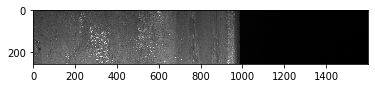

In [34]:
plt.imshow(plt_img)

In [35]:
saveImage(plt_img.numpy(), os.path.join(rootModelName,'defect_image_initial.jpg'))

# GROUND TRUTH

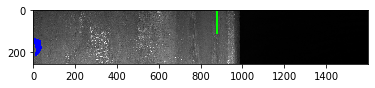

In [36]:
true_defect_img = annotatedImageDefects(plt_img, gt_mask.to('cpu'))
plt.imshow(true_defect_img)

In [37]:
saveImage(true_defect_img, os.path.join(rootModelName, 'defect_image_ground_truth.jpg'))

# Model

In [38]:
loss1Name = 'CE'
loss2Name = 'CE'
modelFile = rootModelName + '_' + loss1Name + '_' + loss2Name + '.pth'
modelInfer = FCN32s(pretrained_net=vgg_model, n_class=numDefectClasses+1)
modelInfer.load_state_dict(torch.load(os.path.join(rootModelName, modelFile)))
modelInfer.to(rundevice)

FCN32s(
  (pretrained_net): VGGNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): ReLU(inplace=True)
      (15): MaxPool2d(k

In [39]:
accuracy = lossCalculator(test_loader, modelInfer, dice_accuracy_batch_no_bg, rundevice)
print('global accuracy: {:.1f}'.format(accuracy))

global accuracy: 2.4


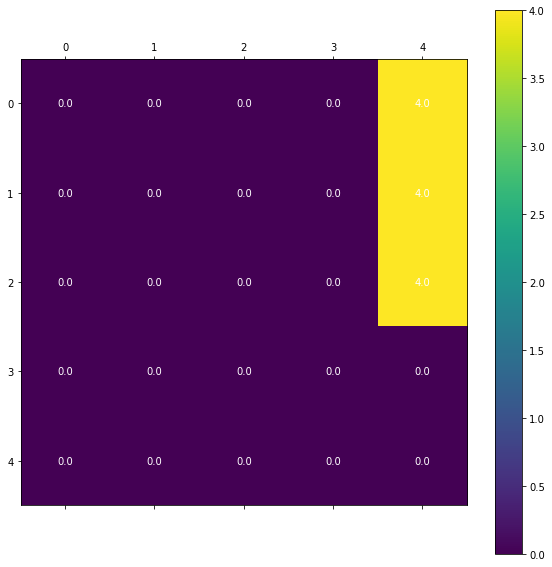

In [40]:
confMat = confusionMatrix(test_loader, modelInfer, rundevice)
showConfusionMatrix(confMat, rootModelName, rootModelName + '_CE_confMat.jpg')

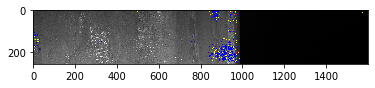

In [41]:
pred_mask_raw_batch = modelInfer(img_batch)
pred_mask = torch.max(pred_mask_raw_batch[0], 0)[1]
pred_defect_img = annotatedImageDefects(plt_img, pred_mask.to('cpu'))
plt.imshow(pred_defect_img) 

In [42]:
print('True mask: {}'.format(countLabels(gt_mask.to('cpu'))))
print('Predicted mask: {}'.format(countLabels(pred_mask.to('cpu'))))
print('Mask area: {:.1f}'.format(100 * maskPercentage(gt_mask.to('cpu'))))

True mask: [406387, 0, 1061, 2152, 0]
Predicted mask: [402046, 263, 249, 5463, 1579]
Mask area: 0.8


In [43]:
saveImage(pred_defect_img, os.path.join(rootModelName,'defect_image_CE.jpg'))

In [44]:
validationaccuracy = lossCalculator(validation_loader, modelInfer, dice_accuracy_batch_no_bg, rundevice)
print('validation accuracy: {:.1f}'.format(validationaccuracy))

validation accuracy: 2.1


In [45]:
def loadLossData(modelName, loss1Name, loss2Name):
    modelFile = modelName + '_' + loss1Name + '_' + loss2Name + '.csv'
    CE_histo = []
    Dice_histo = []
    f = open(os.path.join(modelName, modelFile), 'r')
    next(f)
    reader = csv.reader(f)
    for row in reader:
        CE_histo.append(float(row[1]))
        Dice_histo.append(float(row[2]))
    return np.array(CE_histo), np.array(Dice_histo)

In [46]:
modelNormA_CE, modelNormA_Dice = loadLossData('test_norm', 'CE', 'CE')

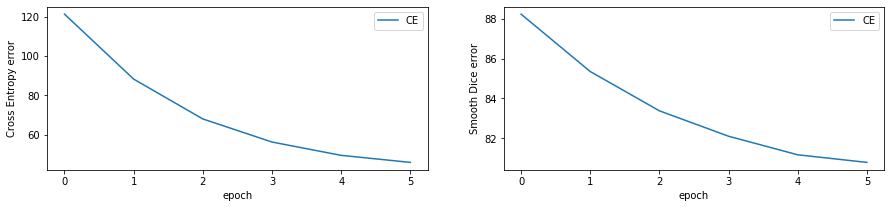

In [47]:
fig, ax = plt.subplots(1,2, figsize = (15,3))

ax[0].plot(modelNormA_CE, label='CE')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('Cross Entropy error')

ax[1].plot(modelNormA_Dice, label='CE')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('Smooth Dice error')

ax[0].legend()
ax[1].legend()

fig.savefig('ErrorsComparison.jpg')

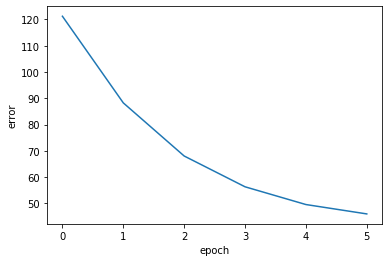

In [48]:
plt.plot(modelNormA_CE, label='Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('error')
plt.savefig('CrossEntropyError_CEModel.jpg')